### 데이터 가져오기

In [2]:
! ls ~/data/data/bike-sharing-demand

sampleSubmission.csv  test.csv	train.csv


In [3]:
import pandas as pd
train = pd.read_csv('~/data/data/bike-sharing-demand/train.csv')

In [4]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


### datetime 컬럼을 datetime 자료형으로 변환하고 연, 월, 일, 시, 분, 초까지 6가지 컬럼 생성하기

In [5]:
dt_index = pd.DatetimeIndex(pd.to_datetime(train['datetime']))

In [6]:
train = train.assign(
    year=dt_index.year, 
    month=dt_index.month,
    day=dt_index.day,
    hour=dt_index.hour, 
    minute=dt_index.minute, 
    second=dt_index.second, 
).drop(columns=['datetime'])


In [7]:
train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,minute,second
0,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,0,0
1,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,0,0
2,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,0,0
3,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,0,0
4,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,0,0


### year, month, day, hour, minute, second 데이터 개수 시각화하기

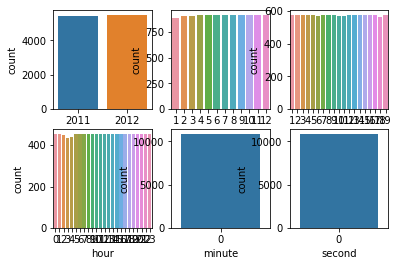

In [8]:
from matplotlib import pyplot as plt
import seaborn as sns

column_names = ['year', 'month', 'day', 'hour', 'minute', 'second']

for i, column in enumerate(column_names):
    ax1 = plt.subplot(2, 3, i+1)
    sns.countplot(x=train[column], ax=ax1)
plt.show()

시간이 고르게 분포. 일부 시간에 빠진 데이터 없음. 수집시 편향 없음

### 결측값 확인 및 처리

In [59]:
train.isnull().sum()

season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
year          0
month         0
day           0
hour          0
minute        0
second        0
dtype: int64

### feature 및 target 사이의 상관관계 분석

<AxesSubplot:>

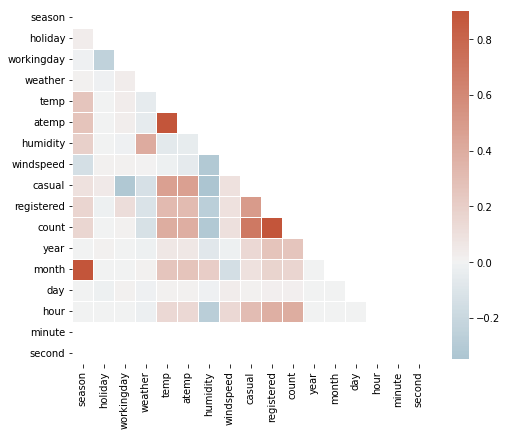

In [50]:
import numpy as np
corr = train.corr() # calculate correlation among numeric features and targets
mask = np.triu(np.ones_like(corr, dtype=bool)) # to hide upper triangle
cmap = sns.diverging_palette(h_neg=230, h_pos=20, as_cmap=True)
plt.figure(figsize=(8,8))
sns.heatmap(corr, 
            mask=mask, # True: hide or False: not
            square=True,
            cmap=cmap, # color map object
            vmax=.9, center=0,
            linewidths=.5, # with of square
            cbar_kws={"shrink": .8} # size of cbar
           )

{'minute', 'second'} 에 대해서 correlation 이 나오지 않음

In [55]:
corr.iloc[-2:, -2:]

,minute,second
minute,NaN,NaN
second,NaN,NaN


In [51]:
train[['minute', 'second']].value_counts()

minute  second
0       0         10886
dtype: int64

값이 하나이기 때문, 정보가 없는 column 으로 판단됨, training 과정에서 제거해도 됨

### target (count), 연관 정보('casual', 'registered', 'workingday')의 분포 확인

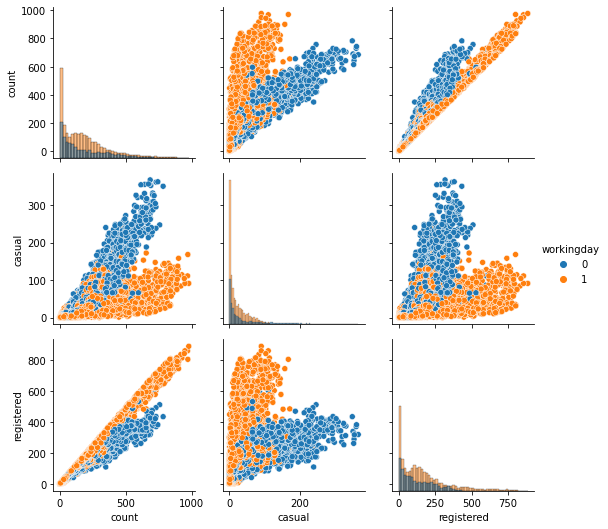

In [48]:
g = sns.PairGrid(train[['count', 'casual', 'registered', 'workingday']], hue='workingday')
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

- working day 에 정기등록(registered) 사용자들과 count 의 상관관계는 높아 보인다. `subplot(1,3)`
- 휴일에는 casual 사용자들과 count 의 상관관계가 높아진다. `subplot(1,2)`
- 휴일, 평일 상관없이 casual, registered 사이에 약한 양의 상관관계를 보인다.

### casual 과  날씨('atemp', 'humidity')와의 관계/분포 확인

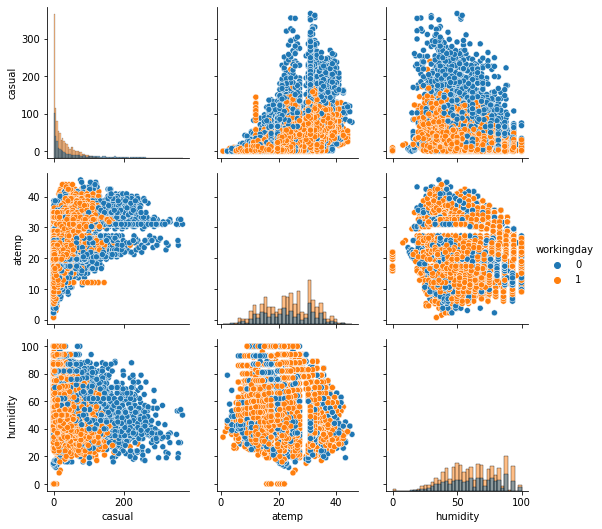

In [57]:
g = sns.PairGrid(train[['casual', 'atemp', 'humidity', 'workingday']], hue='workingday')
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

- 휴일 casual 사용자는 체감 기온이 높고, 습도가 낮을수록 많이 타는것 같다.`subplot(1,2) & (1,3)`
- 평일도 비슷한 경향
- 체감 기온과, 습도는 상관관계 없음.

### X, y 컬럼 선택 및 train/test 데이터 분리

test 에는 casual, registered 에 

In [8]:
X = train.drop(columns = ['casual', 'registered', 'count'])#.values
y = train['count'].values

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### LinearRegression 모델 학습

In [9]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

### 학습된 모델로 X_test에 대한 예측값 출력 및 손실함수값 계산

In [10]:
test = pd.read_csv('~/data/data/bike-sharing-demand/test.csv')
dt_index = pd.DatetimeIndex(pd.to_datetime(test['datetime']))
test = test.assign(
    year=dt_index.year, 
    month=dt_index.month,
    day=dt_index.day,
    hour=dt_index.hour, 
    minute=dt_index.minute, 
    second=dt_index.second, 
).drop(columns=['datetime'])

test.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour,minute,second
0,1,0,1,1,10.66,11.365,56,26.0027,2011,1,20,0,0,0
1,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,1,0,0
2,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,2,0,0
3,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,3,0,0
4,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,4,0,0


In [11]:
from sklearn.metrics import mean_squared_error
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
rmse = mean_squared_error(y_test, predictions, squared=False)
print(f'MSE: {mse}, RMSE: {rmse}')

MSE: 19945.370053754035, RMSE: 141.22807813517124


### x축은 temp 또는 humidity로, y축은 count로 예측 결과 시각화하기

<AxesSubplot:xlabel='temp'>

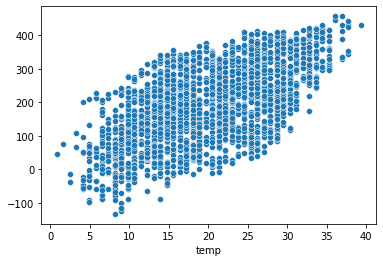

In [12]:
sns.scatterplot(x=X_test['temp'], y=predictions)

<AxesSubplot:xlabel='humidity'>

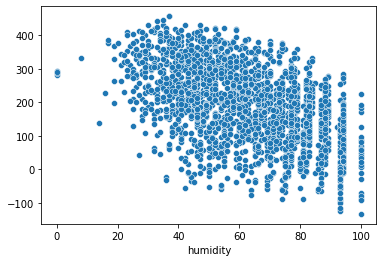

In [13]:
sns.scatterplot(x=X_test['humidity'], y=predictions)

### 평가문항 상세기준
1. 프로젝트 1의 회귀모델 예측정확도가 기준 이상 높게 나왔는가?
    - [x] MSE 손실함수값 3000 이하를 달성
2. 프로젝트 2의 회귀모델 예측정확도가 기준 이상 높게 나왔는가?
    - [x] RMSE 값 150 이하를 달성
3. 시각화 요구사항이 정확하게 이루어졌는가?
    - [x] 각 프로젝트 진행 과정에서 요구하고 있는 데이터개수 시각화 및 예측결과 시각화를 모두 진행하였다.